# Predicting aces with an SVD recommender model

**Goal:** Build a machine learning recommender system that predicts the number of aces that will occur between two professional tennis players. I have chosen to use collaborative filtering to generate a prediction of match total match aces given two tennis players.

**The dataset:** 4,572 tennis matches that have occurred in 18 Grand Slam tennis tournaments between 2019 and 2023.

**Columns:** The original dataset contains the following columns:

 'X',
 'tourney_id',
 'tourney_name',
 'surface',
 'tourney_date',
 'match_date',
 'match_num',
 'round',
 'best_of',
 'gender',
 'winner_id',
 'winner_seed',
 'winner_rank',
 'winner_name',
 'winner_age',
 'winner_rating_score',
 'winner_serve_ability',
 'loser_id',
 'loser_seed',
 'loser_rank',
 'loser_name',
 'loser_age',
 'loser_rating_score',
 'loser_serve_ability',
 'score',
 'minutes',
 'winner_aces',
 'winner_double_faults',
 'winner_service_points',
 'winner_first_serves_in',
 'winner_first_serves_won',
 'winner_second_serves_won',
 'winner_break_points_saved',
 'winner_break_points_faced',
 'winner_sets',
 'winner_games',
 'loser_aces',
 'loser_double_faults',
 'loser_service_points',
 'loser_first_serves_in',
 'loser_first_serves_won',
 'loser_second_serves_won',
 'loser_break_points_saved',
 'loser_break_points_faced',
 'loser_sets',
 'loser_games'

**Limitations:** 
Recommender systems cannot handle changes in preferences (or in this case, changes in serve ability) over time. It assumes the serve ability of a player remains constant even though players can improve their serve by practicing. Conversely, a player they may lose their serve ability by negelecting practice, obtaining an injury, or getting "the yips")

In [62]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise.model_selection.validation import cross_validate
from surprise import accuracy

In [63]:
# Reading the original data file
tennis_df = pd.read_excel("tennis.xlsx")

In [64]:
# Create aces dictionary function. 
# This function will be used to reformat the original data.
# We want a separate row for each server instead of a seperate row for each match

def aces_dict_add(row):
    aces_dict_data["server"].append(row["winner_name"])
    aces_dict_data["returner"].append(row["loser_name"])
    aces_dict_data["X"].append(row["X"])
    aces_dict_data["match_num"].append(row["match_num"])
    aces_dict_data["WorL"].append("W")
    aces_dict_data["aces"].append(row["winner_aces"])
    aces_dict_data["male_or_female"].append(row["gender"])

    aces_dict_data["server"].append(row["loser_name"])
    aces_dict_data["returner"].append(row["winner_name"])
    aces_dict_data["X"].append(row["X"])
    aces_dict_data["match_num"].append(row["match_num"])
    aces_dict_data["WorL"].append("L")
    aces_dict_data["aces"].append(row["loser_aces"])
    aces_dict_data["male_or_female"].append(row["gender"])

    return aces_dict_data

In [65]:
# Create the aces dictionary:

aces_dict_data = {"server":[],
                  "returner":[],
                  "X":[],
                  "match_num":[],
                  "WorL":[],
                  "aces":[],
                  "male_or_female":[]
                 }

tennis_df.apply(aces_dict_add, axis=1)

# Transform the data back into a dataframe with the structure we want:
aces_df = pd.DataFrame.from_dict(aces_dict_data)

## Aces among men and women 
Male and female tennis players do not play against each other in professional competitions. There are also big differences in the prevalence of aces in mens and women's tennis. Thus, when building a model to predict the number of aces that would occur between two opponents if makes sense to account for this difference. 

In this instance, we will train and test our model on male tennis players. 

In [66]:
# Select only the male tennis players:
aces_df_male = aces_df[aces_df["male_or_female"]=="male"][["server","returner","aces"]]

In [67]:
# Make sure we get rid of aces values that are NaN because this will impact 
# our model's ability to make predictions

aces_df_male = aces_df_male[aces_df_male["aces"].notna()]

## Handling duplicate server/returner pairs

It is important to remove duplicate server/returner pairs by calculating the averate
number of aces that the server achieves agains a particular opponent. do this because the surprise package expects a unique value 
for each server/ returner pair:

In [68]:
# Handle duplicates server/returner pairs by averaging the ratings.
aces_df_male = aces_df_male.groupby(["server","returner"])["aces"].mean().reset_index()

In [69]:
# min and max ratings will be used to normalize the ratings later:
min_aces = min(aces_df_male["aces"])
max_aces = max(aces_df_male["aces"])

print(f"min aces are {min_aces} and max aces are {max_aces}")

min aces are 0.0 and max aces are 54.0


## Creating a utility matrix

Because I am using the surprise package I need the data to be in a format equivalent to a "User-Item-Rating Triplet" which is common to recommender systems. In this case it will be a Server, Returner, Aces triplet. 

The Surprise library often works with data in the form of triplets: (user, item, rating). Each row represents the number of aces a server achieved in a match against a particular returner.

In [70]:
# In this step we make sure the data is in the correct format for the surprise package
reader = Reader(rating_scale=(min_aces, max_aces))
surprise_data = Dataset.load_from_df(aces_df_male[["server","returner","aces"]], reader)

In [71]:
# Divide the surprise data into a trainset and a testset. 
trainset, testset = train_test_split(surprise_data, test_size=.1, random_state=42)

# TRYING TO CREATE A UTILITY MATRIX

In [72]:
num_users = trainset.n_users
num_items = trainset.n_items

# Initialize the utility matrix with zeros
utility_matrix = np.zeros((num_users, num_items))

# Populate the utility matrix with ratings
for (uid, iid, rating) in trainset.all_ratings():
    utility_matrix[int(uid), int(iid)] = rating

<Axes: >

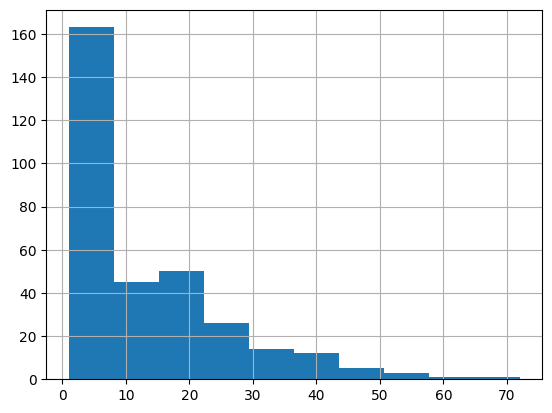

In [87]:
aces_df_male["server"].value_counts().hist()

In [83]:
aces_df_male["returner"].value_counts()

returner
Novak Djokovic        72
Daniil Medvedev       58
Alexander Zverev      57
Stefanos Tsitsipas    54
Rafael Nadal          51
                      ..
Nicola Kuhn            1
Ethan Quinn            1
Mikael Torpegaard      1
Mattia Bellucci        1
Shintaro Mochizuki     1
Name: count, Length: 320, dtype: int64

In [76]:
utility_matrix_df = pd.DataFrame(utility_matrix, columns=)
utility_matrix_df

,0,1,2,3,4,5,6,7,8,9,...,297,298,299,300,301,302,303,304,305,306
0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,12.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
def add_matches_to_testset(player1, player2):
    aces = aces_df_male[(aces_df_male["server"] == player2) & (aces_df_male["returner"] == player1)]["aces"].tolist()[0]
    output = (player2, player1, aces)
    return output

In [23]:
# find the testset "matches" and add them to the testset
testset_additions = []
for item in testset:
    testset_additions.append(add_matches_to_testset(item[0], item[1]))

testset += testset_additions

In [24]:
svd = SVD(n_epochs=3)

cross_validate(
    svd, 
    surprise_data, 
    measures=['RMSE', 'MAE'], 
    cv=3, 
    verbose=True
)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    6.1490  5.9714  6.1070  6.0758  0.0758  
MAE (testset)     4.6122  4.5610  4.6629  4.6120  0.0416  
Fit time          0.01    0.01    0.00    0.01    0.00    
Test time         0.01    0.00    0.00    0.00    0.00    


{'test_rmse': array([6.14902088, 5.97139194, 6.10695331]),
 'test_mae': array([4.61223614, 4.56096555, 4.66289742]),
 'fit_time': (0.008154869079589844,
  0.0059010982513427734,
  0.003772735595703125),
 'test_time': (0.005533933639526367,
  0.003701925277709961,
  0.003014087677001953)}

## predicting the number of aces a server achieves against a particular opponent:

In [25]:
# NOTE: This is the error associated with predicting the number of aces a particular 
# server gets when playing agains a particular opponent

predictions = svd.test(testset)
rmse_ = round(accuracy.rmse(predictions), 3)
rmse_

RMSE: 5.8346


5.835

In [29]:
def generate_ace_prediction(model, server, returner):
    """
    Generates predictions with the SVD model.
    """
    pred_set = [(server, returner, 0)] #Establish the data format
    prediction = model.test(pred_set)

    for pred in prediction:
        return pred.est

In [30]:
def total_match_aces_prediction(player1, player2):
    return generate_ace_prediction(svd, player1, player2) + generate_ace_prediction(svd, player2, player1)

In [31]:
## Testing the model:

In [32]:
def total_match_aces_true(player1, player2):
    condition1 = ((aces_df_male["server"] == player1) & (aces_df_male["returner"] == player2))
    condition2 = ((aces_df_male["server"] == player2) & (aces_df_male["returner"] == player1))
    return aces_df_male[condition1 | condition2]["aces"].sum()

In [33]:
def prediction_vs_reality(player1, player2):
    pred = total_match_aces_prediction(player1, player2)
    true_val = total_match_aces_true(player1, player2)
    return f"The model predicts {pred} aces between these players when in reality there are on average {true_val} aces"

In [20]:
aces_df_male.head()

,server,returner,aces
0,Adrian Mannarino,Albert Ramos,2.0
1,Adrian Mannarino,Alex De Minaur,2.0
2,Adrian Mannarino,Alexander Shevchenko,9.0
3,Adrian Mannarino,Alexander Zverev,4.0
4,Adrian Mannarino,Aljaz Bedene,8.0


In [34]:
testset_df = pd.DataFrame(testset, columns=["server","returner","aces"])
testset_df.shape

(824, 3)

In [37]:
def apply_server_predictor(row):
    return generate_ace_prediction(svd, row["server"], row["returner"])

In [40]:
testset_df["server_aces_prediction"] = testset_df.apply(apply_server_predictor, axis=1)

In [42]:
testset_df.head()

,server,returner,aces,server_aces_prediction
0,Alexander Zverev,Fabio Fognini,14.0,11.040451
1,Jiri Lehecka,Francisco Cerundolo,6.0,7.639405
2,Reilly Opelka,Cedrik Marcel Stebe,11.0,10.628500
3,Hugo Dellien,Alex De Minaur,4.0,6.721706
4,Lorenzo Sonego,Emilio Gomez,5.0,8.658241


In [39]:
testset_df.head()

,server,returner,aces
0,Alexander Zverev,Fabio Fognini,14.0
1,Jiri Lehecka,Francisco Cerundolo,6.0
2,Reilly Opelka,Cedrik Marcel Stebe,11.0
3,Hugo Dellien,Alex De Minaur,4.0
4,Lorenzo Sonego,Emilio Gomez,5.0


In [43]:
testset_df_1 = testset_df.iloc[:412]
testset_df_2 = testset_df.iloc[412:]
testset_df_2 = testset_df_2.rename(columns={"server":"server2", "returner":"returner2", "aces":"aces2", "server_aces_prediction":"server_aces_prediction2"}).reset_index(drop=True)

In [46]:
test = pd.merge(testset_df_1, testset_df_2, left_index=True, right_index=True)
test["total_aces"] = test["aces"] + test["aces2"]
test["total_aces_predicted"] = test["server_aces_prediction"] + test["server_aces_prediction2"]

In [47]:
test.head()

,server,returner,aces,server_aces_prediction,server2,returner2,aces2,server_aces_prediction2,total_aces,total_aces_predicted
0,Alexander Zverev,Fabio Fognini,14.0,11.040451,Fabio Fognini,Alexander Zverev,2.0,7.428829,16.0,18.469280
1,Jiri Lehecka,Francisco Cerundolo,6.0,7.639405,Francisco Cerundolo,Jiri Lehecka,0.0,7.861067,6.0,15.500472
2,Reilly Opelka,Cedrik Marcel Stebe,11.0,10.628500,Cedrik Marcel Stebe,Reilly Opelka,2.0,8.787718,13.0,19.416218
3,Hugo Dellien,Alex De Minaur,4.0,6.721706,Alex De Minaur,Hugo Dellien,7.0,7.678700,11.0,14.400405
4,Lorenzo Sonego,Emilio Gomez,5.0,8.658241,Emilio Gomez,Lorenzo Sonego,0.0,6.916651,5.0,15.574892


In [48]:
def apply_predictor(row):
    return total_match_aces_prediction(row["server"], row["returner"])

In [49]:
test["predicted_aces"] = test.apply(apply_predictor, axis=1)

In [50]:
test.head(20)

,server,returner,aces,server_aces_prediction,server2,returner2,aces2,server_aces_prediction2,total_aces,total_aces_predicted,predicted_aces
0,Alexander Zverev,Fabio Fognini,14.0,11.040451,Fabio Fognini,Alexander Zverev,2.0,7.428829,16.0,18.469280,18.469280
1,Jiri Lehecka,Francisco Cerundolo,6.0,7.639405,Francisco Cerundolo,Jiri Lehecka,0.0,7.861067,6.0,15.500472,15.500472
2,Reilly Opelka,Cedrik Marcel Stebe,11.0,10.628500,Cedrik Marcel Stebe,Reilly Opelka,2.0,8.787718,13.0,19.416218,19.416218
3,Hugo Dellien,Alex De Minaur,4.0,6.721706,Alex De Minaur,Hugo Dellien,7.0,7.678700,11.0,14.400405,14.400405
4,Lorenzo Sonego,Emilio Gomez,5.0,8.658241,Emilio Gomez,Lorenzo Sonego,0.0,6.916651,5.0,15.574892,15.574892
5,Yu Hsiou Hsu,Thanasi Kokkinakis,7.0,8.442801,Thanasi Kokkinakis,Yu Hsiou Hsu,16.0,9.921626,23.0,18.364426,18.364426
6,Roberto Bautista Agut,J J Wolf,6.0,7.606892,J J Wolf,Roberto Bautista Agut,14.0,9.844571,20.0,17.451463,17.451463
7,Karen Khachanov,Bernabe Zapata Miralles,11.0,8.942526,Bernabe Zapata Miralles,Karen Khachanov,1.0,7.158012,12.0,16.100538,16.100538
8,Jiri Vesely,Christopher Oconnell,16.0,9.717991,Christopher Oconnell,Jiri Vesely,11.0,9.643943,27.0,19.361934,19.361934
9,Guido Andreozzi,Laslo Djere,5.0,7.889855,Laslo Djere,Guido Andreozzi,12.0,8.583312,17.0,16.473167,16.473167


In [29]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [51]:
MSE = mean_squared_error(test["total_aces"], test["predicted_aces"])
RMSE = np.sqrt(MSE)
RMSE

9.186098860195372

In [52]:
average_aces = test["total_aces"].mean()
average_aces

17.353964401294498

In [53]:
average_aces_list = [average_aces] * 412

In [54]:
# BASELINE COMPARISON:
MSE_baseline = mean_squared_error(test["total_aces"], average_aces_list)
RMSE_baseline = np.sqrt(MSE_baseline)
RMSE_baseline

10.46989535111225